# 0. GPU 확인

In [1]:
from tensorflow.python.client import device_lib
device_lib.list_local_devices()

[name: "/device:CPU:0"
 device_type: "CPU"
 memory_limit: 268435456
 locality {
 }
 incarnation: 8822647372305088138
 xla_global_id: -1,
 name: "/device:GPU:0"
 device_type: "GPU"
 memory_limit: 6267797504
 locality {
   bus_id: 1
   links {
   }
 }
 incarnation: 10467135322348962544
 physical_device_desc: "device: 0, name: NVIDIA GeForce RTX 2070 SUPER, pci bus id: 0000:01:00.0, compute capability: 7.5"
 xla_global_id: 416903419]

# 1. Create Dataset

In [2]:
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
import os
import glob
import random
import cv2

## 1.1. data path

In [3]:
test_data_path = './data/test_data'
test_image_paths = glob.glob(os.path.join(test_data_path, '*'))
test_image_paths

['./data/test_data\\DSCF1859.JPG',
 './data/test_data\\DSCF1880.JPG',
 './data/test_data\\ILSVRC2012_val_00000070.JPEG',
 './data/test_data\\ILSVRC2012_val_00000546.JPEG',
 './data/test_data\\ILSVRC2012_val_00000846.JPEG',
 './data/test_data\\ILSVRC2012_val_00000979.JPEG',
 './data/test_data\\ILSVRC2012_val_00001320.JPEG',
 './data/test_data\\ILSVRC2012_val_00001340.JPEG',
 './data/test_data\\ILSVRC2012_val_00002213.JPEG',
 './data/test_data\\ILSVRC2012_val_00002543.JPEG',
 './data/test_data\\ILSVRC2012_val_00003648.JPEG',
 './data/test_data\\ILSVRC2012_val_00003946.JPEG',
 './data/test_data\\ILSVRC2012_val_00004338.JPEG',
 './data/test_data\\ILSVRC2012_val_00004405.JPEG',
 './data/test_data\\ILSVRC2012_val_00004806.JPEG',
 './data/test_data\\ILSVRC2012_val_00004833.JPEG',
 './data/test_data\\ILSVRC2012_val_00005584.JPEG',
 './data/test_data\\ILSVRC2012_val_00006118.JPEG',
 './data/test_data\\ILSVRC2012_val_00006436.JPEG',
 './data/test_data\\ILSVRC2012_val_00006617.JPEG',
 './data/tes

## 1.2. Custom Dataset Class

In [4]:
class Custom_Image_Dataset(Dataset) :
    
    def __init__(self, image_paths, transforms=None):
        self.image_paths = image_paths
        self.transforms = transforms
        
    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img = cv2.imread(self.image_paths[idx])
        
        img_lab = cv2.cvtColor(img, cv2.COLOR_BGR2LAB)
        img_lab_norm = img_lab.astype('float64')
        
        img_lab_norm[:, :, 0] = img_lab_norm[:, :, 0]/255
        img_lab_norm[:, :, 1] = (img_lab_norm[:, :, 1]-42)/184
        img_lab_norm[:, :, 2] = (img_lab_norm[:, :, 2]-20)/203
        
        img_l = np.expand_dims(img_lab_norm[:,:,0], axis = 2)
        img_ab = img_lab_norm[:, :, 1:]
        
        x = img_l
        y = img_ab
        
        if self.transforms is not None :
            x = self.transforms(x).float()
            y = self.transforms(y).float()
        
        return x, y

## 1.3. Data Load

In [5]:
transform = transforms.Compose([
    transforms.ToTensor()
])

In [6]:
test_dataset = Custom_Image_Dataset(test_image_paths, transform)
test_dataloader = DataLoader(test_dataset, batch_size = 4, shuffle = False)

# 2. Load Model

In [7]:
import torch
import torch.nn as nn

In [8]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

## 2.1. define model function

In [9]:
class UNET(nn.Module) :
    def __init__(self) :
        super().__init__()
        
        def conv(in_dim, out_dim) :
            model = nn.Sequential(
                nn.Conv2d(in_dim, out_dim, kernel_size=3, padding='same'),
                nn.BatchNorm2d(out_dim),
                nn.ReLU(inplace=True),
                nn.Conv2d(out_dim, out_dim, kernel_size=3, padding='same'),
                nn.BatchNorm2d(out_dim),
                nn.ReLU(inplace=True)
            )
            return model
        
        def max_pool() :
            model = nn.MaxPool2d(2)
            return model
        
        def up_conv(in_dim, out_dim) :
            model = nn.Sequential(
                nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True),
                nn.Conv2d(in_dim, out_dim, kernel_size=2, padding='same')
            )
            return model
        
        self.input = nn.Sequential()
        self.enc1 = conv(1, 64)
        self.enc2 = nn.Sequential(max_pool(), conv(64, 128))
        self.enc3 = nn.Sequential(max_pool(), conv(128, 256))
        self.enc4 = nn.Sequential(max_pool(), conv(256, 512))
        self.enc5 = nn.Sequential(max_pool(), conv(512, 1024))
        
        self.dec1 = up_conv(1024, 512)
        self.dec2 = nn.Sequential(conv(1024, 512), up_conv(512, 256))
        self.dec3 = nn.Sequential(conv(512, 256), up_conv(256, 128))
        self.dec4 = nn.Sequential(conv(256, 128), up_conv(128, 64))
        self.dec5 = conv(128, 64)
        self.out = nn.Conv2d(64, 2, kernel_size=1, padding = 'same')
        
        
        
    def forward(self, x):
        x = self.input(x)
        x1 = self.enc1(x)
        x2 = self.enc2(x1)
        x3 = self.enc3(x2)
        x4 = self.enc4(x3)
        x5 = self.enc5(x4)
        
        x = self.dec1(x5)
        x = torch.cat([x, x4], dim = 1)
        x = self.dec2(x)
        x = torch.cat([x, x3], dim = 1)
        x = self.dec3(x)
        x = torch.cat([x, x2], dim = 1)
        x = self.dec4(x)
        x = torch.cat([x, x1], dim = 1)
        x = self.dec5(x)
        x = self.out(x)
        
        
        return x

## 2.2. model compile

In [10]:
trained_model_UNET = UNET().to(device)

## 2.3. load trained state dict path

In [11]:
trained_state_dict_path = './data/model_saved/checkpoint_UNET_LAB.pt'

## 2.3. load saved model 

In [12]:
trained_model_UNET.load_state_dict(torch.load(trained_state_dict_path, map_location=device))

<All keys matched successfully>

# 3. Test

In [13]:
import numpy as np
from tqdm.notebook import tqdm

## 3.1. test function

In [14]:
def test_model(model, test_dataloader) :
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    
    test_data_list = []
    test_output_list = []
    test_target_list = []
    model.eval()
    
    test_dataloader_tqdm = tqdm(test_dataloader, desc="Test  ")
    for test_data, test_target in test_dataloader_tqdm :
        test_data = test_data.to(device)
        test_target = test_target.to(device)
        
        test_output = model(test_data)
        
        test_data_list.append(test_data.cpu().detach().numpy())
        test_output_list.append(test_output.cpu().detach().numpy())
        test_target_list.append(test_target.cpu().detach().numpy())
        
        del test_data
        del test_target
        del test_output
        torch.cuda.empty_cache()
    
    x = np.concatenate(test_data_list, axis = 0)
    y_predicted = np.concatenate(test_output_list, axis = 0)
    y_real = np.concatenate(test_target_list, axis = 0)
    
    torch.cuda.empty_cache()
    print("predict completed")
    
    return x, y_predicted, y_real

## 3.2. predict

In [15]:
x_test_L, y_test_predicted_AB, y_test_real_AB = test_model(trained_model_UNET, test_dataloader)

Test  :   0%|          | 0/25 [00:00<?, ?it/s]

C:\Users\T921\anaconda3\lib\site-packages\torch\nn\modules\conv.py:442: UserWarning: Using padding='same' with even kernel lengths and odd dilation may require a zero-padded copy of the input be created (Triggered internally at  ..\aten\src\ATen\native\Convolution.cpp:647.)
  return F.conv2d(input, weight, bias, self.stride,


predict completed


In [16]:
y_test_predicted_AB.shape

(100, 2, 128, 128)

In [17]:
y_test_predicted_AB

array([[[[0.471377  , 0.46817544, 0.46870098, ..., 0.46941262,
          0.46903867, 0.47115174],
         [0.4689513 , 0.4654188 , 0.46629417, ..., 0.46617424,
          0.46570247, 0.46836054],
         [0.4704345 , 0.4671591 , 0.469658  , ..., 0.46747386,
          0.46664104, 0.4689502 ],
         ...,
         [0.4638854 , 0.4602341 , 0.46347785, ..., 0.4680148 ,
          0.4605827 , 0.4635613 ],
         [0.46474892, 0.45918646, 0.4602113 , ..., 0.46794453,
          0.4630326 , 0.46506032],
         [0.46905795, 0.46499658, 0.46355528, ..., 0.4722535 ,
          0.46824154, 0.46931818]],

        [[0.54680836, 0.5430399 , 0.5434565 , ..., 0.5424058 ,
          0.54219365, 0.5465875 ],
         [0.5414923 , 0.5367656 , 0.5386328 , ..., 0.53767407,
          0.5363354 , 0.54234004],
         [0.54114205, 0.5392795 , 0.543216  , ..., 0.5427058 ,
          0.53790545, 0.5429996 ],
         ...,
         [0.54956865, 0.5466906 , 0.5485265 , ..., 0.5580423 ,
          0.54626   , 0.5

## 3.3. LAB De-Normalization and Conatenate 

In [18]:
def lab_concat_de_norm(L, AB) :

    l = L.copy()
    ab = AB.copy()
    l[:,0,:,:] = l[:,0,:,:]*255

    ab[:,0,:,:] = ab[:,0,:,:]*184 + 42
    ab[:,1,:,:] = ab[:,1,:,:]*203 + 20

    lab = np.concatenate((l, ab), axis = 1)    
    return lab

In [19]:
y_test_predicted_LAB = lab_concat_de_norm(x_test_L, y_test_predicted_AB)
y_test_real_LAB = lab_concat_de_norm(x_test_L, y_test_real_AB)

## 3.4. 채널 위치 변경 

In [20]:
print(y_test_predicted_LAB.shape)
print(y_test_real_LAB.shape)

(100, 3, 128, 128)
(100, 3, 128, 128)


In [21]:
y_test_predicted_LAB = y_test_predicted_LAB.swapaxes(1, 3).swapaxes(1, 2)
y_test_real_LAB = y_test_real_LAB.swapaxes(1, 3).swapaxes(1, 2)
print(y_test_predicted_LAB.shape)
print(y_test_real_LAB.shape)

(100, 128, 128, 3)
(100, 128, 128, 3)


## 3.5. LAB2RGB

In [22]:
def lab_2_rgb(y_test_LAB) :
    y_test_LAB_uint = y_test_LAB.astype('uint8')
    
    y_test_RGB = np.empty((0, 128, 128, 3), dtype=np.uint8)
    for img_lab in y_test_LAB_uint :
        img_rgb = cv2.cvtColor(img_lab, cv2.COLOR_LAB2RGB)
        img_rgb = np.expand_dims(img_rgb, axis = 0)
        y_test_RGB = np.append(y_test_RGB, img_rgb, axis=0)
    
    return y_test_RGB

In [23]:
y_test_predicted = lab_2_rgb(y_test_predicted_LAB)
y_test_real = lab_2_rgb(y_test_real_LAB)

## 3.6. X_test

In [24]:
x_test = x_test_L.copy()
x_test[:,0,:,:] = x_test[:,0,:,:]*255
x_test = x_test.astype('uint8')

# 4. Visualizing Test Result

## 4.1. test result visualizing function

In [25]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.preprocessing import minmax_scale
from tensorflow.keras import backend

In [34]:
def show_images(x, y_predicted, y_real):  

    x = x[:, 0, ...]
    
    n = 10
    plt.figure(figsize=(20, 6))
    for i in range(10):

        ax = plt.subplot(3, n, i + 1)
        if x.ndim < 4:
            plt.imshow(x[i], cmap='gray')
        else:
            plt.imshow(x[i])
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

        ax = plt.subplot(3, n, i + 1 + n)
        plt.imshow(y_predicted[i])
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

        ax = plt.subplot(3, n, i + 1 + n * 2)
        plt.imshow(y_real[i])
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

    plt.show()

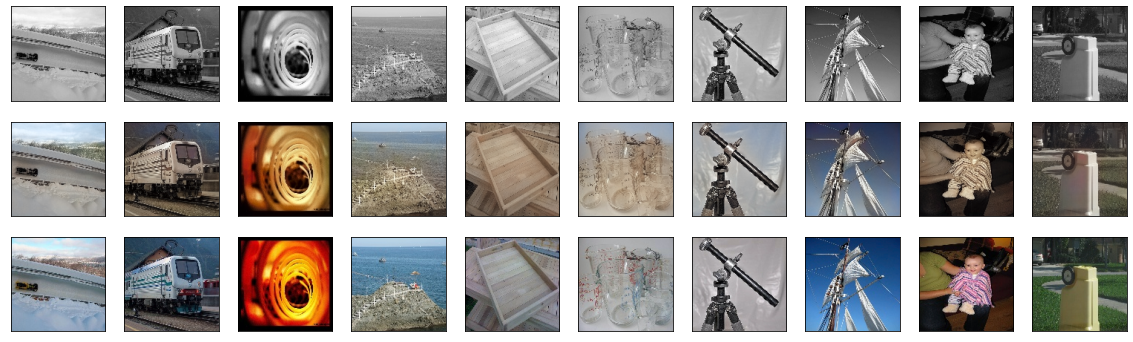

In [35]:
show_images(x_test, y_test_predicted, y_test_real)